In [128]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
scaler=MinMaxScaler()
df=pd.read_csv("daily")
temp_df=df.copy(deep=True)
temp_df["season"].replace({"Winter":0,"Spring":1,"Summer":2,
                        "Autumn":3}, inplace=True)
temp_df["weekday"].replace({"Sun":0,"Mon":1,"Tue":2,"Wed":3,"Thu":4,
                                "Fri":5,"Sat":6}, inplace=True)
temp_df["weather"].replace({"good":0,"cloudy":1,"overcast":2,"rain":3,
                                "snow":4}, inplace=True)
a=["instant", "date", "casual", "registered", "day"]
temp_df.drop(a, axis=1, inplace=True)

Normally we would check our data for missing/junk values, duplicates etc, but since we have worked extensively with this particular dataset, we know it is good.

In [129]:
temp_df["season"]=temp_df["season"].astype("category")
temp_df["weather"]=temp_df["weather"].astype("category")
temp_df["month"]=temp_df["month"].astype("category")
temp_df["weekday"]=temp_df["weekday"].astype("category")

In [130]:
temp_df=pd.get_dummies(temp_df, drop_first=True)
np.random.seed(0)
dftrain, dftest= train_test_split(temp_df, train_size=0.7,
                                    test_size=0.3, random_state=100)
a=["temp", "ftemp", "hum", "windspeed", "cnt"]
dftrain[a]=scaler.fit_transform(dftrain[a])
ytrain=dftrain["cnt"]
xtrain=dftrain.drop("cnt", axis=1)

In [131]:
reg=LinearRegression()
reg.fit(xtrain, ytrain)
rfe=RFE(reg, n_features_to_select=15)
rfe=rfe.fit(xtrain, ytrain)
list(zip(xtrain.columns, rfe.support_, rfe.ranking_))
a=xtrain.columns[rfe.support_]
xtrain_rfe=xtrain[a]

In [132]:
vif=pd.DataFrame()
vif["features"]=xtrain_rfe.columns
vif["vif"]=[variance_inflation_factor(xtrain_rfe.values, i)
            for i in range(xtrain_rfe.shape[1])]
vif["vif"]=round(vif["vif"], 2)
vif=vif.sort_values(by="vif", ascending=False)
xtrain_lr1=sm.add_constant(xtrain_rfe)
lr1=sm.OLS(ytrain, xtrain_lr1).fit()
vif

,features,vif
7,month_6,inf
8,month_7,inf
9,month_8,inf
13,season_2,inf
2,temp,28.40
0,year,25.83
3,hum,12.88
14,season_3,4.97
12,season_1,4.94
4,windspeed,4.71


In [133]:
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     180.5
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          2.45e-184
Time:                        13:24:53   Log-Likelihood:                 498.74
No. Observations:                 511   AIC:                            -967.5
Df Residuals:                     496   BIC:                            -903.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -466.5914     16.807    -27.762      0.0

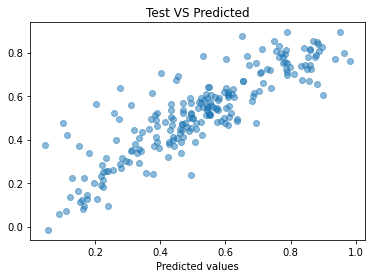

0.7572610829230411

In [134]:
a=["temp", "ftemp", "hum", "windspeed", "cnt"]
temp=dftest.copy(deep=True)
temp[a]=scaler.transform(temp[a])
ytest=temp["cnt"]
xtest=temp.drop("cnt", axis=1)
a=xtrain_rfe.columns
xtest=xtest[a]
xtest_lr1=sm.add_constant(xtest)
ypred=lr1.predict(xtest_lr1)
plt.scatter(ytest, ypred, alpha=0.5)
plt.title("Test VS Predicted")
plt.xlabel("Test values")
plt.xlabel("Predicted values")
plt.show()
r2_score(ytest, ypred)

In [136]:
xtrain_new=xtrain_rfe.drop(["season_2"], axis=1)
vif=pd.DataFrame()
vif["features"]=xtrain_new.columns
vif["vif"]=[variance_inflation_factor(xtrain_new.values, i)
            for i in range(xtrain_new.shape[1])]
vif["vif"]=round(vif["vif"], 2)
vif=vif.sort_values(by="vif", ascending=False)
xtrain_lr2=sm.add_constant(xtrain_new)
lr2=sm.OLS(ytrain, xtrain_lr2).fit()
vif

,features,vif
2,temp,28.40
0,year,25.83
3,hum,12.88
13,season_3,4.97
12,season_1,4.94
4,windspeed,4.71
9,month_8,4.13
8,month_7,4.10
7,month_6,3.25
6,month_5,2.31


In [137]:
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     180.5
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          2.45e-184
Time:                        13:24:54   Log-Likelihood:                 498.74
No. Observations:                 511   AIC:                            -967.5
Df Residuals:                     496   BIC:                            -903.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -466.5914     16.807    -27.762      0.0

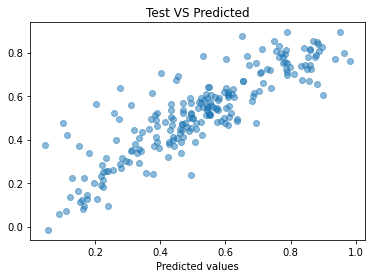

0.7572610829230729

In [138]:
a=["temp", "ftemp", "hum", "windspeed", "cnt"]
temp=dftest.copy(deep=True)
temp[a]=scaler.transform(temp[a])
ytest=temp.pop("cnt")
xtest=temp
a=xtrain_new.columns
xtest=xtest[a]
xtest_lr2=sm.add_constant(xtest)
ypred=lr2.predict(xtest_lr2)
fig=plt.figure()
a=plt.scatter(ytest, ypred, alpha=0.5)
plt.title("Test VS Predicted")
plt.xlabel("Test values")
plt.xlabel("Predicted values")
plt.show()
r2_score(ytest, ypred)

<AxesSubplot:ylabel='Density'>

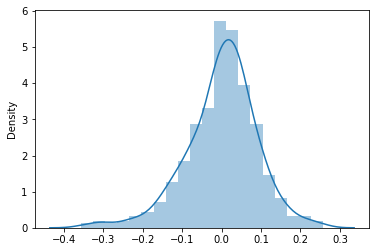

In [139]:
# Error term distribution in our best performing models is normal, which
# means that a linear regression is appropriate
ytrain_pred=lr2.predict(xtrain_lr2)
res=ytrain-ytrain_pred
fig=plt.figure()
sns.distplot(res, bins=20)

In [140]:
xtrain_new=xtrain_rfe.drop(["season_2", "windspeed"], axis=1)
vif=pd.DataFrame()
vif["features"]=xtrain_new.columns
vif["vif"]=[variance_inflation_factor(xtrain_new.values, i)
            for i in range(xtrain_new.shape[1])]
vif["vif"]=round(vif["vif"], 2)
vif=vif.sort_values(by="vif", ascending=False)
xtrain_lr3=sm.add_constant(xtrain_new)
lr3=sm.OLS(ytrain, xtrain_lr3).fit()
vif

,features,vif
2,temp,28.39
0,year,18.35
3,hum,12.60
11,season_1,4.94
12,season_3,4.85
8,month_8,4.09
7,month_7,4.04
6,month_6,3.23
5,month_5,2.30
4,month_4,1.88


In [141]:
print(lr3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     137.0
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          7.07e-155
Time:                        13:24:55   Log-Likelihood:                 425.89
No. Observations:                 511   AIC:                            -823.8
Df Residuals:                     497   BIC:                            -764.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -474.5675     19.349    -24.526      0.0

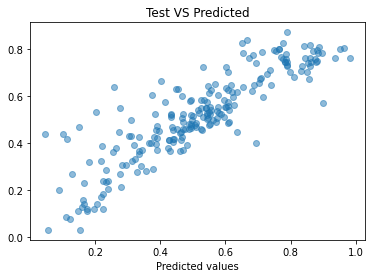

0.764935138506476

In [142]:
a=["temp", "ftemp", "hum", "windspeed", "cnt"]
temp=dftest.copy(deep=True)
temp[a]=scaler.transform(temp[a])
ytest=temp.pop("cnt")
xtest=temp
a=xtrain_new.columns
xtest=xtest[a]
xtest_lr3=sm.add_constant(xtest)
ypred=lr3.predict(xtest_lr3)
fig=plt.figure()
plt.scatter(ytest, ypred, alpha=0.5)
plt.title("Test VS Predicted")
plt.xlabel("Test values")
plt.xlabel("Predicted values")
plt.show()
r2_score(ytest, ypred)

In [146]:
xtrain_new=xtrain_rfe.drop(["season_2", "windspeed", "month_7"], axis=1)
vif=pd.DataFrame()
vif["features"]=xtrain_new.columns
vif["vif"]=[variance_inflation_factor(xtrain_new.values, i)
            for i in range(xtrain_new.shape[1])]
vif["vif"]=round(vif["vif"], 2)
vif=vif.sort_values(by="vif", ascending=False)
xtrain_lr4=sm.add_constant(xtrain_new)
lr4=sm.OLS(ytrain, xtrain_lr4).fit()
vif

,features,vif
0,year,18.16
3,hum,12.36
2,temp,10.64
10,season_1,3.81
11,season_3,2.71
5,month_5,2.04
4,month_4,1.84
7,month_8,1.78
6,month_6,1.56
8,month_10,1.54


In [144]:
print(lr4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     123.6
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          9.37e-141
Time:                        13:24:56   Log-Likelihood:                 389.71
No. Observations:                 511   AIC:                            -753.4
Df Residuals:                     498   BIC:                            -698.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -495.5580     20.586    -24.073      0.0

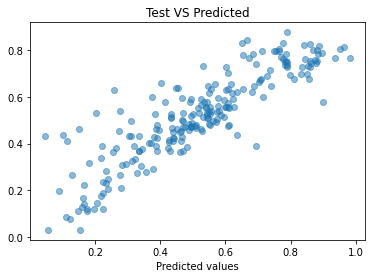

0.7642269354417763

In [147]:
a=["temp", "ftemp", "hum", "windspeed", "cnt"]
temp=dftest.copy(deep=True)
temp[a]=scaler.transform(temp[a])
ytest=temp.pop("cnt")
xtest=temp
a=xtrain_new.columns
xtest=xtest[a]
xtest_lr4=sm.add_constant(xtest)
ypred=lr4.predict(xtest_lr4)
fig=plt.figure()
plt.scatter(ytest, ypred, alpha=0.5)
plt.title("Test VS Predicted")
plt.xlabel("Test values")
plt.xlabel("Predicted values")
plt.show()
r2_score(ytest, ypred)

In [ ]:
# Error term distribution in our best performing models is normal, which
# means that a linear regression is appropriate
ytrain_pred=lr1.predict(xtrain_lr1)
res=ytrain-ytrain_pred
fig=plt.figure()
sns.distplot(res, bins=20)